In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pt
import time

In [0]:
file_root = '/content/drive/My Drive/VLSI/Wallace.isc'

In [0]:
def parse_iscas(file):
  print("Parsing Started!!!")
  
  split_list = file.split('\n')
  No_gates=0

  for op in split_list:
    if '=' in op:
      No_gates += 1

  output_array = []
  input_array = []

  for op in split_list:
    if 'INPUT' in op:
      No_gates += 1
      open_brace_index = op.find('(',0)
      close_brace_index = op.find(')',0)
      op_G = op[open_brace_index+1:close_brace_index]
      inp=int(op_G[1:])
      output_array.append(inp)
      input_array.append([-1])

  adj_mx = np.zeros((No_gates,No_gates))

  for op in split_list:
    if '=' in op:
      G_index = op.find('G',0)
      equal_index = op.find('=',0)
      out = int(op[G_index+1:equal_index-1])
      output_array.append(out)


  for op in split_list:
    if '=' in op:
      open_brace_index = op.find('(',0)
      close_brace_index = op.find(')',0)
      op_sub = op[open_brace_index+1:close_brace_index]
      op_sub_G_list = op_sub.split(',')
      in_array = []
      for item in op_sub_G_list:
        G_index = item.find('G',0)
        inp = int(item[G_index+1:])
        in_array.append(inp)
      input_array.append(in_array)

  for i in range(len(input_array)):
    for j in range(len(input_array[i])):
      if(input_array[i][j]!=-1):
        adj_mx_i = output_array.index(input_array[i][j])
        adj_mx_j = i
        adj_mx[adj_mx_i][adj_mx_j] = 1

  print("Successfully Parsed!!!")

  return adj_mx


In [19]:
with open (file_root, "r") as myfile:
    file=myfile.read()

adj_mx = parse_iscas(file)

Parsing Started!!!
Successfully Parsed!!!


In [0]:
def Draw_Partitioned_Graph(ad_mx,part_a,part_b):
  part_a_len = len(part_a)
  part_b_len = len(part_b)

  pos_part_a=nx.circular_layout(part_a,scale=8,center=[10,10])
  pos_part_b=nx.circular_layout(part_b,scale=8,center=[35,10])

  pos_part_a_keys = pos_part_a.keys()
  pos_part_b_keys = pos_part_b.keys()
  
  fig,ax=plt.subplots()

  plt.xlim(0,50)
  plt.ylim(0,22.5)

  for x in pos_part_a_keys:
    c=plt.Circle((pos_part_a[x][0],pos_part_a[x][1]),radius=0.5,color='yellow')
    ax.add_artist(c)
    c = plt.Circle((pos_part_a[x][0],pos_part_a[x][1]),radius=0.5,color='black',fill=False)
    ax.add_artist(c)
    plt.annotate("G"+str(x),(pos_part_a[x][0],pos_part_a[x][1]))

  for x in pos_part_b_keys:
    c=plt.Circle((pos_part_b[x][0],pos_part_b[x][1]),radius=0.5,color='yellow')
    ax.add_artist(c)
    c = plt.Circle((pos_part_b[x][0],pos_part_b[x][1]),radius=0.5,color='black',fill=False)
    ax.add_artist(c)
    plt.annotate("G"+str(x),(pos_part_b[x][0],pos_part_b[x][1]))

  for i_row in range(adj_mx.shape[0]):
    for j_col in range(adj_mx.shape[1]):
      if(adj_mx[i_row][j_col]==1):

        if i_row+1 in pos_part_a_keys:
          x1 = pos_part_a[i_row+1][0]
          y1 = pos_part_a[i_row+1][1]
        else:
          x1 = pos_part_b[i_row+1][0]
          y1 = pos_part_b[i_row+1][1]

        if j_col+1 in pos_part_a_keys:
          x2 = pos_part_a[j_col+1][0]
          y2 = pos_part_a[j_col+1][1]
        else:
          x2 = pos_part_b[j_col+1][0]
          y2 = pos_part_b[j_col+1][1]

        plt.plot([x1,x2],[y1,y2],color='black',linewidth=0.4)

  plt.show()

In [0]:
class Edge(object):
    def __init__(self, left, right):
        self.left_id = left
        self.right_id = right

    def set_left_vertex(self, left_vrtx):
        self.left_vertex = left_vrtx
        left_vrtx.add_edge(self)

    def set_right_vertex(self, right_vrtx):
        self.right_vertex = right_vrtx
        right_vrtx.add_edge(self)

In [0]:
class Vertex(object):
    def __init__(self, id):
        self.id = id
        self.edges = []

    def get_id(self):
        return self.id

    def get_edges(self):
        return self.edges

    def get_group(self):
        return self.group

    def set_group(self, group):
        self.group = group

    def add_edge(self, edge):
        for existing_edge in self.edges:
            if existing_edge.left_id == edge.right_id and existing_edge.right_id == edge.left_id:
                return
        self.edges.append(edge)

    def get_cost(self):
        cost = 0
        for edge in self.edges:
            other_vertex = edge.left_vertex
            if edge.left_id != self.id:
                other_vertex = edge.left_vertex
            elif edge.right_id != self.id:
                other_vertex = edge.right_vertex

            if other_vertex.group != self.group:
                cost += 1
            else:
                cost -= 1

        return cost

In [0]:
class Graph(object):
    def __init__(self, vertex, edges):
        self.vertex = vertex
        self.__vertex_map = {vx.get_id() : vx for vx in self.vertex}
        self.edges = edges
        self.cut_size = int(len(self.vertex)/2)
        self.create_random_groups()
        self.__create_links()

    def __create_links(self):
        links_map = {}
        for edge in self.edges:
            edge.set_left_vertex(self.__vertex_map[edge.left_id])
            edge.set_right_vertex(self.__vertex_map[edge.right_id])

    def create_random_groups(self):
        self.group_a = []
        self.group_b = []
        for i in range(self.cut_size):
            self.vertex[i].set_group('A')
            self.group_a.append(self.vertex[i])
        for i in range(self.cut_size, len(self.vertex)):
            self.vertex[i].set_group('B')
            self.group_b.append(self.vertex[i])

    def get_random_groups(self):
        return self.group_a, self.group_b

    def get_groups(self):
        a_group = []
        b_group = []
        for vertex in self.vertex:

            if vertex.get_group() == 'A':
                a_group.append(vertex)
            elif vertex.get_group() == 'B':
                b_group.append(vertex)
        return a_group, b_group

    def get_cut_size(self):
        return self.cut_size

    def get_edges(self):
        return self.edges

    def get_vertexs(self):
        return self.vertex


In [0]:
#KL Algorithm
class KernighanLin(object):
    def __init__(self, graph):
        self.graph = graph
        self.nominal_cut_size = float("Inf")
        self.swaps = []

    def start(self):
        self.group_a_unchosen, self.group_b_unchosen = self.graph.get_random_groups()
        cut_size = self.graph.get_cut_size()   
        min_id = -1
        if self.get_nominal_cut_size() < self.nominal_cut_size:
            self.nominal_cut_size = self.get_nominal_cut_size()
            min_cost = float("Inf")
            for i in range(cut_size):
                self.single_swaps()
                cost = self.get_nominal_cut_size()
                if cost < min_cost:
                    min_cost = cost
                    min_id = i
            
            # Undo swaps done after the minimum was reached
            for i in range(min_id+1, cut_size):
                vertice_b, vertice_a = self.swaps[i]
                self.do_swap((vertice_a, vertice_b))


            self.group_a_unchosen, self.group_b_unchosen = self.graph.get_groups()
        
            print('============')
        
        return self.graph.get_groups()

    def single_swaps(self):
        best_pair = False
        best_heuristic = -1 * float("Inf")

        for vertice_a in self.group_a_unchosen:
            for vertice_b in self.group_b_unchosen:
                cost_edge = len(set(vertice_a.get_edges()).intersection(vertice_b.get_edges()))
                heuristic = vertice_a.get_cost() + vertice_b.get_cost() - 2*cost_edge
                if heuristic > best_heuristic:
                    best_heuristic = heuristic
                    best_pair = vertice_a, vertice_b
        if best_pair:
            vertice_a, vertice_b = best_pair
            self.group_a_unchosen.remove(vertice_a)
            self.group_b_unchosen.remove(vertice_b)
            self.do_swap((vertice_a, vertice_b))
            self.swaps.append(best_pair)

            return best_heuristic
        else:
            raise Exception('empty maximum')
    
    def get_nominal_cut_size(self):
        cost = 0
        for edge in self.graph.get_edges():
            if edge.left_vertex.get_group() != edge.right_vertex.get_group():
                cost += 1

        return cost


    def do_swap(self, vertices):
        vertice_a, vertice_b = vertices

        vertice_a.set_group('B')
        vertice_b.set_group('A')

In [0]:
def Adj_mx_to_graph(adj_mx):
    edges = []
    vertex_ids = []
    vertex = []
    for i_row in range(0,adj_mx.shape[0]):
      for j_col in range(0,adj_mx.shape[1]):
        if(adj_mx[i_row][j_col]==1):
            left = i_row+1
            right = j_col+1
            edges.append(Edge(left, right))
            if left not in vertex_ids:
                vertex_ids.append(left)
                vertex.append(Vertex(left))
            if right not in vertex_ids:
                vertex_ids.append(right);
                vertex.append(Vertex(right))
    return Graph(vertex, edges)

The initial Partioning is as follows:
PARTITION A=[1, 9, 10, 12, 20, 2, 11, 13, 15, 21, 3, 14, 16, 18, 22, 4, 17, 19, 23, 24, 5, 6, 7, 8, 25, 27, 30, 26, 28, 31, 34, 36, 39, 41, 32, 37, 40, 33, 35, 49, 52, 55, 57, 59, 50, 54, 58, 51, 53, 73, 75, 78, 74, 76, 63, 64, 65, 70, 71, 131, 81, 82, 83, 88, 89, 92, 94, 96, 99, 100, 93, 95]
PARTITION B=[101, 133, 136, 139, 141, 143, 29, 44, 46, 48, 38, 43, 45, 42, 61, 67, 69, 47, 103, 106, 108, 56, 62, 66, 60, 80, 84, 87, 68, 104, 105, 72, 109, 112, 115, 117, 119, 77, 79, 85, 91, 97, 86, 110, 114, 118, 90, 121, 124, 127, 129, 98, 122, 126, 130, 102, 134, 138, 142, 107, 111, 113, 116, 120, 123, 125, 128, 132, 135, 137, 140, 144]


The Partition graph before applying KL Algorithm:


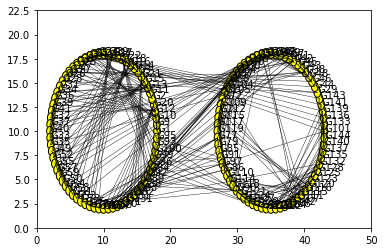



The No of Cuts before applying KL Algorithm:65
Performing KL Algorithm......Please wait!!!
KL Algorithm completed Successfully!!!

The Total Time elapsed:0.4722099304199219 Seconds


The Partioning after applying KL Algorithm is as follows:
PARTITION A=[1, 9, 10, 12, 2, 11, 13, 15, 3, 14, 16, 18, 22, 4, 17, 19, 23, 5, 6, 7, 25, 27, 26, 28, 31, 34, 36, 39, 41, 32, 37, 40, 33, 35, 49, 52, 55, 57, 59, 50, 54, 58, 51, 53, 73, 75, 78, 74, 76, 64, 92, 94, 96, 99, 100, 93, 95, 101, 29, 44, 46, 38, 43, 45, 42, 61, 69, 47, 56, 66, 91, 97]
PARTITION B=[20, 21, 24, 8, 30, 63, 65, 70, 71, 131, 81, 82, 83, 88, 89, 133, 136, 139, 141, 143, 48, 67, 103, 106, 108, 62, 60, 80, 84, 87, 68, 104, 105, 72, 109, 112, 115, 117, 119, 77, 79, 85, 86, 110, 114, 118, 90, 121, 124, 127, 129, 98, 122, 126, 130, 102, 134, 138, 142, 107, 111, 113, 116, 120, 123, 125, 128, 132, 135, 137, 140, 144]


The Partition graph after applying KL Algorithm:


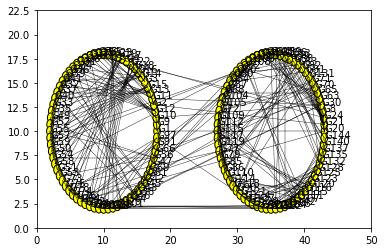



The Cut Size After applying KL Algorithm is:31


In [26]:
graph_KL = Adj_mx_to_graph(adj_mx)

part_a=[]
part_b=[]

group_a,group_b = graph_KL.get_groups()
for v_a,v_b in zip(group_a,group_b):
  part_a.append(v_a.get_id())
  part_b.append(v_b.get_id())

print("The initial Partioning is as follows:\nPARTITION A="+str(part_a)+"\nPARTITION B="+str(part_b))
print("\n\nThe Partition graph before applying KL Algorithm:")
Draw_Partitioned_Graph(adj_mx,part_a,part_b)

part_a=[]
part_b=[]

kl = KernighanLin(graph_KL)

print("\n\nThe No of Cuts before applying KL Algorithm:"+str(kl.get_nominal_cut_size()))

print("Performing KL Algorithm......Please wait!!!")
ini_time = time.time()
group_a,group_b=kl.start()
final_time = time.time()
print("KL Algorithm completed Successfully!!!")
print("\nThe Total Time elapsed:"+str(final_time-ini_time)+" Seconds")
for v_a,v_b in zip(group_a,group_b):
  part_a.append(v_a.get_id())
  part_b.append(v_b.get_id())

print("\n\nThe Partioning after applying KL Algorithm is as follows:\nPARTITION A="+str(part_a)+"\nPARTITION B="+str(part_b))

print("\n\nThe Partition graph after applying KL Algorithm:")
Draw_Partitioned_Graph(adj_mx,part_a,part_b)

print("\n\nThe Cut Size After applying KL Algorithm is:"+ str(kl.get_nominal_cut_size()))

In [0]:
#Simulated Annealing

class Simulated_Annealing(object):
      def __init__(self, graph,t,r):
        self.graph = graph
        self.t = t
        self.r = r
        self.part_a,self.part_b = self.graph.get_random_groups()
        _,self.curr_score = self.score(self.part_a,self.part_b)
        self.cost_plot=[[0],[self.curr_score]]

      def score(self,part_a,part_b):
        cost = 0
        for vertex in part_a:
          for edge in vertex.edges:
            other_vertex = edge.left_vertex
            if edge.left_id != vertex.id:
                other_vertex = edge.left_vertex
            elif edge.right_id != vertex.id:
                other_vertex = edge.right_vertex

            if other_vertex in part_b:
                cost += 1
  
        return cost,(cost/(len(part_a)*len(part_b)))

      def select(self,part):
        random_index = np.random.randint(len(part))
        return part[random_index]
      
      def exchange(self,vertice_a,vertice_b):
        trial_part_a = []
        trial_part_b = []
        for v_a,v_b in zip(self.part_a,self.part_b):
          trial_part_a.append(v_a)
          trial_part_b.append(v_b)
        trial_part_a.remove(vertice_a)
        trial_part_b.remove(vertice_b)
        trial_part_a.append(vertice_b)
        trial_part_b.append(vertice_a)
        return trial_part_a,trial_part_b
      
      def Move_part(self,vertice_a,vertice_b):
        self.part_a.remove(vertice_a)
        self.part_b.remove(vertice_b)
        vertice_a.set_group('B')
        vertice_b.set_group('A')
        return self.graph.get_groups()

      def start(self):
        for i in range(150):
          for j in range(150):
            vertice_a = self.select(self.part_a)
            vertice_b = self.select(self.part_b)
            trial_part_a,trial_part_b = self.exchange(vertice_a,vertice_b)
            #print([a.get_id() for a in self.part_a])
            #print([a.get_id() for a in trial_part_a])
            _,trial_score = self.score(trial_part_a,trial_part_b)
            delta_s = trial_score - self.curr_score
            if delta_s < 0:
              self.curr_score = trial_score
              self.part_a,self.part_b = self.Move_part(vertice_a,vertice_b)
            else:
              alpha = np.random.rand()
              if(alpha < np.exp(-delta_s/self.t)):
                self.curr_score = trial_score
                self.part_a,self.part_b = self.Move_part(vertice_a,vertice_b)
            
          self.cost_plot[0].append(i+1)
          self.cost_plot[1].append(self.curr_score)
          self.t = self.r*self.t
         
      def Draw_cost_plot(self):
        plt.plot(self.cost_plot[0],self.cost_plot[1])
        plt.xlabel("No of Iterations")
        plt.ylabel("Cost")
        plt.show()

The Cut Size before Simulated Annealing:65

Performing Simulated Annealing Algorithm.....Please wait!!!


Simulated Annealing completed Successfully!!!

The total time elapsed:6.711315870285034 Seconds

The Cut Size after Simulated Annealing:24


The Cost vs No Iterations Graph:


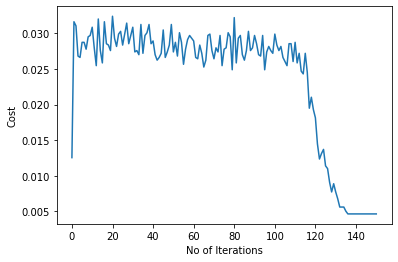



The Partitioned Graph after Simulated Annealing:


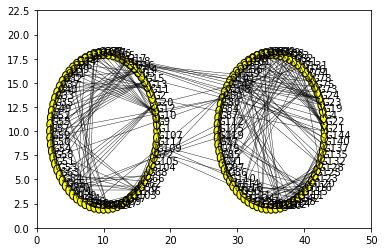

In [34]:
graph_SA = Adj_mx_to_graph(adj_mx)
SA = Simulated_Annealing(graph_SA,100,0.9)
cost,_ = SA.score(SA.part_a,SA.part_b)
print("The Cut Size before Simulated Annealing:"+str(cost))
print("\nPerforming Simulated Annealing Algorithm.....Please wait!!!")
ini_time=time.time()
SA.start()
print("\n\nSimulated Annealing completed Successfully!!!")
final_time=time.time()
print("\nThe total time elapsed:"+str(final_time - ini_time) + str(" Seconds"))
cost,_=SA.score(SA.part_a,SA.part_b)
print("\nThe Cut Size after Simulated Annealing:"+str(cost))

print("\n\nThe Cost vs No Iterations Graph:")
SA.Draw_cost_plot()

part_a=[]
part_b=[]
for v_a,v_b in zip(SA.part_a,SA.part_b):
  part_a.append(v_a.get_id())
  part_b.append(v_b.get_id())

print("\n\nThe Partitioned Graph after Simulated Annealing:")
Draw_Partitioned_Graph(adj_mx,part_a,part_b)